In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
import optuna 
from sklearn.model_selection import KFold
from optuna.integration import LightGBMPruningCallback
import warnings
warnings.filterwarnings("ignore")

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [43]:
all_data = pd.read_csv('resources/data_position_poi.csv')

In [4]:
NUMERIC_FEATURES = ["latitude", "longitude", "constructed", "area_total",
            "rooms", "balconies", "loggias", "metro_distance", "park_distance",
            "square_distance", "stories","floor", "ceiling", "bathrooms_shared", "bathrooms_private", "phones"]
CATEGORICAL_FEATURES = ["seller", "district", "material", "condition", "heating", "new", 
                "layout", "windows_court", "windows_street", "parking", "garbage_chute", "elevator_passenger", "elevator_without", "elevator_service"]

In [44]:
all_data[CATEGORICAL_FEATURES] = all_data[CATEGORICAL_FEATURES].astype('category')

#log transform skewed numeric features:

skewed_feats = all_data[NUMERIC_FEATURES].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [45]:
data = all_data.loc[all_data['split'] == 'train', :]
data = data.drop(columns=['split'])

data_test = all_data.loc[all_data['split'] == 'test', :]
data_test = data_test.drop(columns=['split', 'price'])

In [46]:
def objective_lgb(trial, X, y, area, categorical):
    params = {
        'verbose': -1,
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': 2000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02, 0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 3, 60)
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    pruning_callback = LightGBMPruningCallback(trial, "rmse")

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = np.log(y[train_idx]/area[train_idx])
        y_test = np.log(y[test_idx]/area[test_idx])

        lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
        lgb_eval = lgb.Dataset(X_test, y_test,free_raw_data=False)
        model = lgb.train(params, 
                        lgb_train, valid_sets=lgb_eval, 
                        verbose_eval=False, callbacks = [pruning_callback], early_stopping_rounds=100,
                        categorical_feature=categorical)
    
        preds = np.exp(model.predict(X_test)) * area[test_idx]
        y_true = np.exp(y_test) * area[test_idx]
        cv_scores[idx] = rmlse(y_true, preds)
    
    return np.mean(cv_scores)


In [48]:
X = data.drop(columns=['price', 'address', 'street'])
y = data.price
area = data.area_total

study = optuna.create_study(direction="minimize", study_name="LGB Regressor")
func = lambda trial: objective_lgb(trial, X, y, area, CATEGORICAL_FEATURES)
study.optimize(func, n_trials=20)

[I 2021-11-04 20:12:30,156] A new study created in memory with name: LGB Regressor
[I 2021-11-04 20:13:47,908] Trial 0 finished with value: 0.15483360718450634 and parameters: {'reg_alpha': 0.0851384086002242, 'reg_lambda': 0.13264808493868468, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 160, 'min_child_samples': 160, 'cat_smooth': 57}. Best is trial 0 with value: 0.15483360718450634.
[I 2021-11-04 20:14:19,284] Trial 1 finished with value: 0.14317206833438362 and parameters: {'reg_alpha': 0.26490929334873126, 'reg_lambda': 9.03743511297198, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 275, 'min_child_samples': 147, 'cat_smooth': 38}. Best is trial 1 with value: 0.14317206833438362.
[I 2021-11-04 20:15:07,427] Trial 2 finished with value: 0.14779799040718836 and parameters: {'reg_alpha': 2.7381443712123343, 'reg_lambda': 0.11215025331226847, 'colsample_bytree': 0.9, 'subsample': 0

KeyboardInterrupt: 

In [19]:
params = study.best_params
params['random_state'] = 42
params['metric'] = 'rmse'
params['n_estimators'] = 2000
params['verbose'] =  -1

lgb_train = lgb.Dataset(X, y, free_raw_data=False)

lgb_mod = lgb_mod = lgb.train(
    params,
    lgb_train,
    categorical_feature= CATEGORICAL_FEATURES
)

In [41]:
X_test = data_test.drop(columns=['address', 'street'])
preds_test = np.exp(lgb_mod.predict(X_test)) * data_test['area_total']
print(preds_test)
print(preds_test.values)
submission = pd.DataFrame()
submission['id'] = preds_test.index
submission['price_prediction'] = preds_test.values
print(submission.price_prediction)
submission.to_csv('submissions/lgbm_submission.csv', index=False)

23285    1.215312e+08
23286    1.205510e+08
23287    2.337451e+08
23288    7.355464e+07
23289    7.088024e+07
             ...     
33217    1.269650e+07
33218    4.810919e+07
33219    3.421105e+07
33220    4.424858e+07
33221    3.079111e+07
Name: area_total, Length: 9937, dtype: float64
[1.21531224e+08 1.20551007e+08 2.33745117e+08 ... 3.42110491e+07
 4.42485811e+07 3.07911080e+07]
0       1.215312e+08
1       1.205510e+08
2       2.337451e+08
3       7.355464e+07
4       7.088024e+07
            ...     
9932    1.269650e+07
9933    4.810919e+07
9934    3.421105e+07
9935    4.424858e+07
9936    3.079111e+07
Name: price_prediction, Length: 9937, dtype: float64


In [42]:
submission

,id,price_prediction
0,23285,1.215312e+08
1,23286,1.205510e+08
2,23287,2.337451e+08
3,23288,7.355464e+07
4,23289,7.088024e+07
...,...,...
9932,33217,1.269650e+07
9933,33218,4.810919e+07
9934,33219,3.421105e+07
9935,33220,4.424858e+07


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

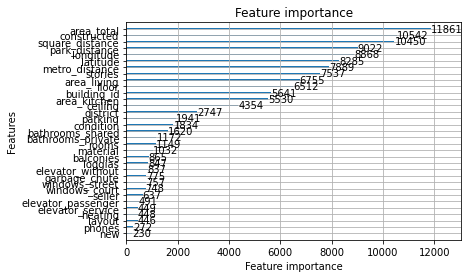

In [20]:
lgb.plot_importance(lgb_mod)